# Оптимизация производственных расходов металлургического комбината ООО «Так закаляем сталь»

## Данные о проекте: 

### Цель проекта: 
Целью проекта является построение модели, которая предсказывает температуру стали в процессе ее обработки с целью оптимизации энергопотребления на этапе производства.

### Описание проекта

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc_new.csv` — данные об электродах;
- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new.csv` — данные о продувке сплава газом;
- `data_temp_new.csv` — результаты измерения температуры;
- `data_wire_new.csv` — данные о проволочных материалах (объём);
- `data_wire_time_new.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### План решения задачи:

1)Предварительный анализ данных: изучение каждого файла с данными, обработка пропущенных значений и выбросов, а также объединение необходимых данных.

2)Создание признаков: создание новых признаков на основе доступных данных.

3)Построение модели: выбор подходящей модели машинного обучения (например, линейная регрессия, случайный лес или градиентный бустинг), обучение модели на подготовленных данных и оценка ее качества.

4)Оптимизация модели: настройка гиперпараметров модели и применение методов оптимизации для улучшения ее качества.

5)Валидация модели: оценка качества модели кросс-валидацией на обучающей выборке, подбор лучших параметров и модели.

6)Финальная проверка лучшей модели на тестовой выборке



**Цель проекта выраженная в результате метрики качества модели:**
Целью проекта является построение модели, которая предсказывает температуру стали в процессе ее обработки с целью оптимизации энергопотребления на этапе производства. Метрика оценки качества модели **MAE (mean absolute error) со значением MAE ≤ 6.8**


## Изучение информации: 

In [1]:
from sklearn.model_selection import train_test_split,cross_val_score, RandomizedSearchCV,GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


RANDOM_STATE = 50623

In [2]:
df_arc = pd.read_csv('/datasets/data_arc_new.csv')
df_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
df_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
df_gas = pd.read_csv('/datasets/data_gas_new.csv')
df_temp = pd.read_csv('/datasets/data_temp_new.csv')
df_wire = pd.read_csv('/datasets/data_wire_new.csv')
df_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [3]:
def status(data):

    print(data.head())
    print()
    print('Информация о датасете: ')
    print(data.info())
    print('------------------------')
    print('Количество пропусков в данных')
    print(data.isna().sum())
    print('------------------------')
    print('Количество дупликатов в данных:', data.duplicated().sum())
    print('------------------------')
    print(data.describe())

In [4]:
status(df_arc)

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 no

- В данных нет пропусков и дубликатов. 
- Название столбцов выглядит неточным - их следует поменять на этапе переработки. 
- Столбцы 'Начало нагрева дугой' и 'Конец нагрева дугой' , исходя из их названия, должны иметь другой формат.
- В столбце 'Реактивная мощность' некоторые данные  имеют отрицательные значения. Такие данные будет необходимо удалить

Проверим как выгледят данные в столбце 'Реактивная мощность' распределяются в минимальных значениях.

In [5]:
df_arc.sort_values(by = ['Реактивная мощность']).head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


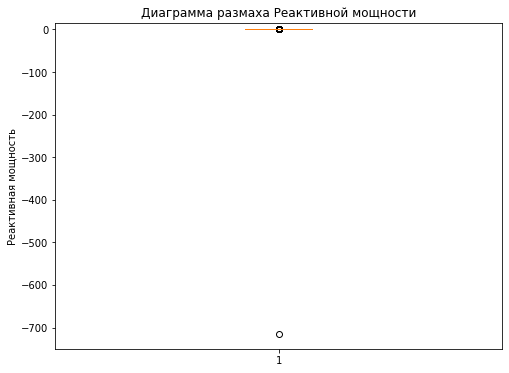

In [6]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_arc['Реактивная мощность'])
plt.ylabel('Реактивная мощность')
plt.title('Диаграмма размаха Реактивной мощности')
plt.ylim(-750, 16)
plt.show()

Т.к такое значение только одно - вероятнее всего это выброс. Эту строку нужно удалить

Проверим распределения данных в гистограммах

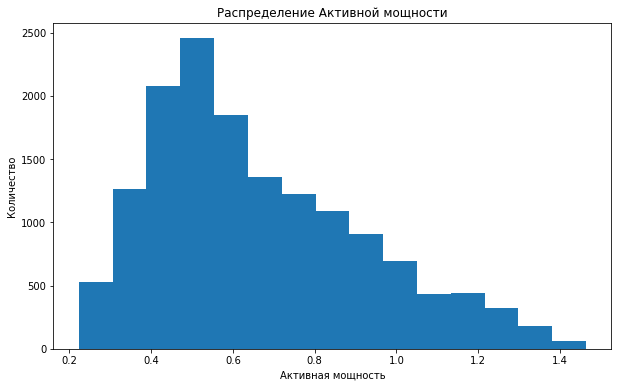

In [7]:
arc_power_ax = df_arc['Активная мощность'].plot(kind='hist', bins=15,figsize=(10, 6));

arc_power_ax.set_title('Распределение Активной мощности');
arc_power_ax.set_ylabel('Количество');
arc_power_ax.set_xlabel('Активная мощность');

Выбросов не наблюдает. Значения распределеяются нормально

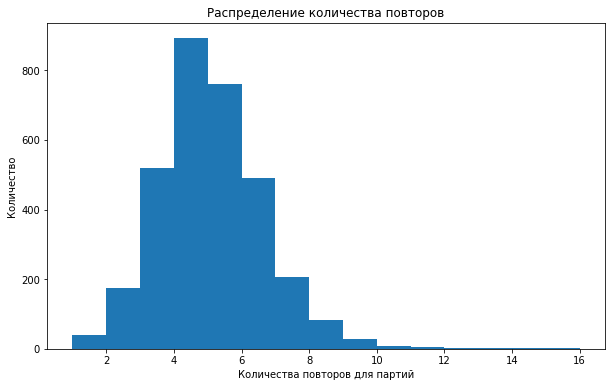

In [8]:
arc_power_ax_count = df_arc.groupby('key')['Активная мощность'].count()

ax = arc_power_ax_count.plot(kind='hist', bins=15, figsize=(10, 6))

ax.set_title('Распределение количества повторов')
ax.set_ylabel('Количество')
ax.set_xlabel('Количества повторов для партий')

plt.show()

Исходя из графика видно что среднее число итераций на "варку" в диапозоне 4-6

Переходим к изученю сыпучих материалов

In [9]:
status(df_bulk)

   key  Bulk 1  Bulk 2  Bulk 3  Bulk 4  Bulk 5  Bulk 6  Bulk 7  Bulk 8  \
0    1     NaN     NaN     NaN    43.0     NaN     NaN     NaN     NaN   
1    2     NaN     NaN     NaN    73.0     NaN     NaN     NaN     NaN   
2    3     NaN     NaN     NaN    34.0     NaN     NaN     NaN     NaN   
3    4     NaN     NaN     NaN    81.0     NaN     NaN     NaN     NaN   
4    5     NaN     NaN     NaN    78.0     NaN     NaN     NaN     NaN   

   Bulk 9  Bulk 10  Bulk 11  Bulk 12  Bulk 13  Bulk 14  Bulk 15  
0     NaN      NaN      NaN    206.0      NaN    150.0    154.0  
1     NaN      NaN      NaN    206.0      NaN    149.0    154.0  
2     NaN      NaN      NaN    205.0      NaN    152.0    153.0  
3     NaN      NaN      NaN    207.0      NaN    153.0    154.0  
4     NaN      NaN      NaN    203.0      NaN    151.0    152.0  

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Coun

В данных имеются пропуски. Посмотрим как выглядят данные о времени подачи сыпучих материалов

In [10]:
status(df_bulk_time)

   key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1    NaN    NaN    NaN  2019-05-03 11:28:48    NaN    NaN    NaN    NaN   
1    2    NaN    NaN    NaN  2019-05-03 11:36:50    NaN    NaN    NaN    NaN   
2    3    NaN    NaN    NaN  2019-05-03 12:32:39    NaN    NaN    NaN    NaN   
3    4    NaN    NaN    NaN  2019-05-03 12:43:22    NaN    NaN    NaN    NaN   
4    5    NaN    NaN    NaN  2019-05-03 13:30:47    NaN    NaN    NaN    NaN   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0    NaN     NaN     NaN  2019-05-03 11:24:31     NaN  2019-05-03 11:14:50   
1    NaN     NaN     NaN  2019-05-03 11:53:30     NaN  2019-05-03 11:48:37   
2    NaN     NaN     NaN  2019-05-03 12:27:13     NaN  2019-05-03 12:21:01   
3    NaN     NaN     NaN  2019-05-03 12:58:00     NaN  2019-05-03 12:51:11   
4    NaN     NaN     NaN  2019-05-03 13:30:47     NaN  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  


- Дубликатов в данных нет. 
- Пропуски повторяются в тех же самых строках. Вероятно это связано с тем что некоторые сыпучие материалы не использовались во время определенной партии. 
- Форматы данных в df_bulk_time необходимо заменить на соотвествующий
- Пропуски в данных о подаче сыпучих материалов будет необходимо заменить нулями

Рассмотрим данные о продувке сплава газом 

In [11]:
status(df_gas)

   key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None
------------------------
Количество пропусков в данных
key      0
Газ 1    0
dtype: int64
------------------------
Количество дупликатов в данных: 0
------------------------
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040


Пропусков и дубликатов в данных нет. Но сразу заметно что название столбца нужно заменить и привести к стандарту

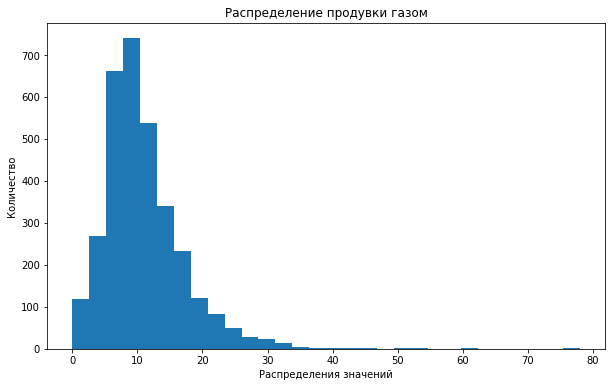

In [12]:
#Построим гистограмму и рассмотрим данные на графике
gas_hist= df_gas['Газ 1'].plot(kind='hist', bins=30,figsize=(10, 6))
gas_hist.set_xlabel('Распределения значений')
gas_hist.set_ylabel('Количество')
plt.title('Распределение продувки газом');


Распределение нормально, выбросов нет.

В данных о продувке газом мы не имеем дополнительных таблиц или столбцов внутри данных к привязке времени, как для данных с сыпучими материалами и проволоками. Предобработка данных не требуется. Нужно только заменить название столбца как отметили ранее

In [13]:
status(df_temp)

   key         Время замера  Температура
0    1  2019-05-03 11:02:04       1571.0
1    1  2019-05-03 11:07:18       1604.0
2    1  2019-05-03 11:11:34       1618.0
3    1  2019-05-03 11:18:04       1601.0
4    1  2019-05-03 11:25:59       1606.0

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None
------------------------
Количество пропусков в данных
key                0
Время замера       0
Температура     3427
dtype: int64
------------------------
Количество дупликатов в данных: 0
------------------------
                key   Температура
count  18092.000000  14665.000000
mean    1616.460977   1590.722741
std      934.641385 

В данных нет дубликатов, но имеются пропуски - нужно проверить их отдельно. Сразу заметно что у данных о времени замера неверный формат, также названия столбцов нужно привести к стандарту.

Попробуем рассмотреть пропуски в данных о температуре более детально

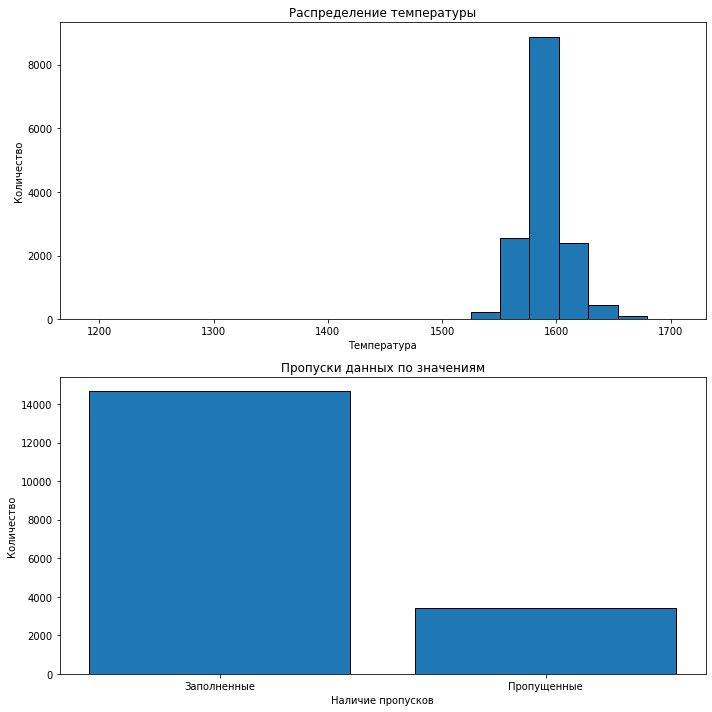

In [14]:
missing_values = df_temp['Температура'].isnull().value_counts()


# Построение гистограммы
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Гистограмма распределения температуры
ax1.hist(df_temp['Температура'].dropna(), bins=20, edgecolor='black')
ax1.set_xlabel('Температура')
ax1.set_ylabel('Количество')
ax1.set_title('Распределение температуры')

# Гистограмма пропусков данных
ax2.bar(['Заполненные', 'Пропущенные'], missing_values, edgecolor='black')
ax2.set_xlabel('Наличие пропусков')
ax2.set_ylabel('Количество')
ax2.set_title('Пропуски данных по значениям')

plt.tight_layout()
plt.show()

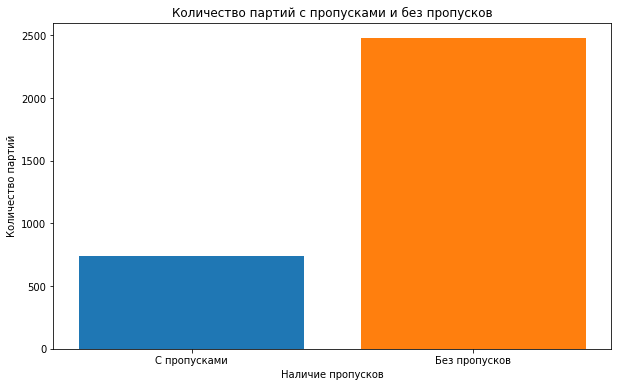

Количество партий с пропусками: 739


In [15]:
# Рассмотрение пропусков в данных для каждой партии
missing_parties = df_temp[df_temp['Температура'].isnull()]['key'].nunique()


plt.figure(figsize=(10, 6))
plt.bar('С пропусками', missing_parties)
plt.bar('Без пропусков', df_temp['key'].nunique() - missing_parties)
plt.xlabel('Наличие пропусков')
plt.ylabel('Количество партий')
plt.title('Количество партий с пропусками и без пропусков')
plt.show()

print(f'Количество партий с пропусками: {missing_parties}')

Для более точного исследования можно в данных оставить только те значения, где мы знаем все температуры для каждой партии, без пропусков

In [16]:
status(df_wire)

   key     Wire 1   Wire 2  Wire 3  Wire 4  Wire 5  Wire 6  Wire 7  Wire 8  \
0    1  60.059998      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
1    2  96.052315      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2    3  91.160157      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3    4  89.063515      NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4    5  89.238236  9.11456     NaN     NaN     NaN     NaN     NaN     NaN   

   Wire 9  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     fl

Дубликатов нет, названия столбцов можно привести к нижнему регистру. Форматы значений правильные. Но есть пропуски, так же как и в данных о сыпучих материалах. Рассмотри связаны ли эти пропуски с данными в df_wire_time

In [17]:
status(df_wire_time)

   key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                  NaN    NaN    NaN    NaN    NaN   
1    2  2019-05-03 11:36:50                  NaN    NaN    NaN    NaN    NaN   
2    3  2019-05-03 12:11:46                  NaN    NaN    NaN    NaN    NaN   
3    4  2019-05-03 12:43:22                  NaN    NaN    NaN    NaN    NaN   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34    NaN    NaN    NaN    NaN   

  Wire 7 Wire 8 Wire 9  
0    NaN    NaN    NaN  
1    NaN    NaN    NaN  
2    NaN    NaN    NaN  
3    NaN    NaN    NaN  
4    NaN    NaN    NaN  

Информация о датасете: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-n

Пропуски как и в данных о сыпучих материала выгледят одинаково в датасетах df_wire_time и df_wire. Поэтмоу пропуски будем заполнять нулями

### **Вывод по первичному анализу данных:**
- В данных нет дубликатов
- Имеются пропуски в значениях которые связаны с тем что на определенных "варках" стали сыпучие материалы или проволоки не добавлялись, можно заменить их нулями.
- Есть выброс в значениях Реактивной мощности. Его необходимо удалить
- Неверные форматы для некоторых данных. Их нужно поменять
- Не стандартные названия столбцов в некоторых датасетах. Их нужно привести к единому стандартному виду
- Данные о партиях где есть потери в измерениях температуры можно удалить для повышени точности модели

**Список уточняющих вопросов:**

- Какие именно данные из файлов необходимо использовать для построения модели предсказания температуры стали?
- Есть ли какие-то ограничения на использование определенных типов данных или признаков?
- Какова точность, с которой модель должна предсказывать температуру стали?
- Есть ли дополнительные факторы, которые могут влиять на температуру стали и были не упомянуты в предоставленной информации?

## Переработка данных

**Внесем изменени:**
- Поменяем форматы для некоторых данных
- Приведем названия столбцов в некоторых датасетах к стандартному виду
- Удалим выброс в значениях Реактивной мощности
- Удалим данные о партиях где есть потери в измерениях температуры
- Пропуски в значениях добавления свыпучих материалов и проволок заполним нулями

In [18]:
#Приведем названия столбцов в некоторых датасетах к стандартному виду
df_arc.columns = ['key', 'arc_heat_start', 'arc_heat_end', 'active_power', 'reactive_power']
df_gas.columns = ['key', 'gas']
df_temp.columns = ['key', 'date_check', 'temp']

In [19]:
#Приведем форматы столбцов в некоторых датасетах к стандартному виду
df_temp['date_check'] = pd.to_datetime(df_temp['date_check'])
df_arc['arc_heat_start'] = pd.to_datetime(df_arc['arc_heat_start'])
df_arc['arc_heat_end'] = pd.to_datetime(df_arc['arc_heat_end'])

columns_to_convert = ['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 
                      'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']

# Изменение формата данных на datetime
df_bulk_time[columns_to_convert] = df_bulk_time[columns_to_convert].apply(pd.to_datetime)

columns_to_convert = ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8']

df_wire_time[columns_to_convert] = df_wire_time[columns_to_convert].apply(pd.to_datetime)

In [20]:
#Удалим выборос из данныз об электродах
df_arc=df_arc[df_arc['reactive_power']> -10]

In [21]:
df_arc.sort_values(by = ['reactive_power']).head()

,key,arc_heat_start,arc_heat_end,active_power,reactive_power
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525
9014,1954,2019-07-21 06:26:02,2019-07-21 06:29:01,0.235934,0.157519


In [22]:
#Данные о материалах с пропусками заполняем нулями
df_bulk = df_bulk.fillna(0)
df_wire = df_wire.fillna(0)


In [23]:
df_bulk.info()
df_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------ 

In [24]:
#Удалим партии с пропусками значений в датасете о результатах температур 

df_temp = df_temp.dropna()
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         14665 non-null  int64         
 1   date_check  14665 non-null  datetime64[ns]
 2   temp        14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


In [25]:
#Определим первую температуру и последнюю температуру
df_temp_table = df_temp.pivot_table(index='key', aggfunc=['max','min'])
df_temp_table= df_temp_table.reset_index()

df_temp_table.columns=['key','datetime','temp_end','temp_first','temp_start']
df_temp_table



,key,datetime,temp_end,temp_first,temp_start
0,1,2019-05-03 11:30:38,1618.0,2019-05-03 11:02:04,1571.0
1,2,2019-05-03 11:55:09,1604.0,2019-05-03 11:34:04,1577.0
2,3,2019-05-03 12:35:57,1600.0,2019-05-03 12:06:44,1596.0
3,4,2019-05-03 12:59:47,1625.0,2019-05-03 12:39:27,1601.0
4,5,2019-05-03 13:36:39,1602.0,2019-05-03 13:11:03,1576.0
...,...,...,...,...,...
3211,3237,2019-09-06 11:31:15,1569.0,2019-09-06 11:31:15,1569.0
3212,3238,2019-09-06 12:16:15,1584.0,2019-09-06 12:16:15,1584.0
3213,3239,2019-09-06 14:16:50,1598.0,2019-09-06 14:16:50,1598.0
3214,3240,2019-09-06 15:25:21,1617.0,2019-09-06 15:25:21,1617.0


In [26]:
#Посмотрим сколько уникальных значений у датасета температур

df_temp['key'].value_counts()

2108    17
1513    16
1689    16
322     14
46      14
        ..
3236     1
2963     1
2955     1
2947     1
2525     1
Name: key, Length: 3216, dtype: int64

In [27]:
#Проверим сколько было измрений температур для каждой партии отдельно
df_temp_group = df_temp.groupby('key').count()
df_temp_group

,date_check,temp
key,,
1,6,6
2,5,5
3,6,6
4,5,5
5,5,5
...,...,...
3237,1,1
3238,1,1
3239,1,1


In [28]:
df_temp_group.describe()

,date_check,temp
count,3216.000000,3216.000000
mean,4.560012,4.560012
std,2.406343,2.406343
min,1.000000,1.000000
25%,3.000000,3.000000
50%,5.000000,5.000000
75%,6.000000,6.000000
max,17.000000,17.000000


array([[<AxesSubplot:title={'center':'date_check'}>,
        <AxesSubplot:title={'center':'temp'}>]], dtype=object)

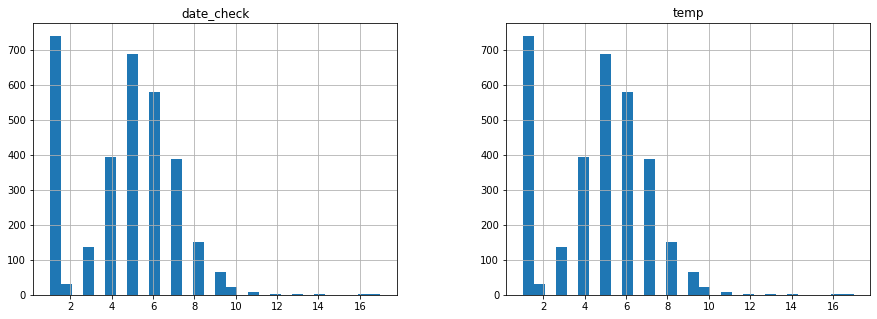

In [29]:
df_temp_group.hist(bins= 30, figsize= (15,5))

<AxesSubplot:>

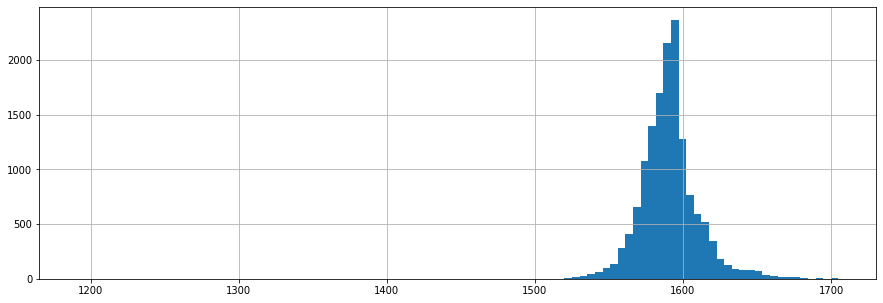

In [30]:
df_temp['temp'].hist(bins= 100, figsize= (15,5))

In [31]:
df_temp_group['temp'].value_counts()

1     741
5     688
6     580
4     395
7     388
8     152
3     136
9      66
2      32
10     21
11      7
12      3
14      2
16      2
13      2
17      1
Name: temp, dtype: int64

В основном 4-6 замеров температур для партии. Но так же есть много партий где был осуществлен всего 1 замер. на гистограме есть значения за пределами температуры 1500 - удалим эти данные, т.к они могут являются выбросами связанными с ошибкой производственного процесса. Данные с менее чем 2мя замерами тоже удалим.

<AxesSubplot:>

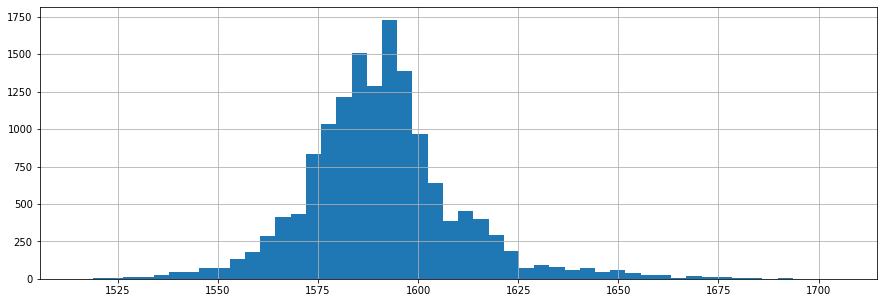

In [32]:
df_temp =df_temp[df_temp['temp']> 1500]
df_temp['temp'].hist(bins= 50, figsize= (15,5))

In [33]:
wrong_temp = df_temp_group.query("temp < 2").index.values

In [34]:
df_temp = df_temp.query('key not in @wrong_temp')
df_temp

,key,date_check,temp
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.0
13922,2499,2019-08-10 13:41:34,1604.0
13923,2499,2019-08-10 13:46:28,1593.0
13924,2499,2019-08-10 13:54:56,1588.0


Создадим списки с измерением температуры в начале и конце. 

In [35]:
df_temp_min = df_temp.groupby('key')['date_check'].transform('min')
df_temp_max = df_temp.groupby('key')['date_check'].transform('max')

dt_by_min = df_temp[df_temp['date_check'].isin(df_temp_min)].copy()
dt_by_max = df_temp[df_temp['date_check'].isin(df_temp_max)].copy()

dt_by_min['date_check'] = pd.to_datetime(dt_by_min['date_check'])
dt_by_max['date_check'] = pd.to_datetime(dt_by_max['date_check'])

df_temp_all = dt_by_min.merge(dt_by_max, on='key', how='left', suffixes=('_first', '_last'))

df_temp_all = df_temp_all.set_index('key')
df_temp_all


,date_check_first,temp_first,date_check_last,temp_last
key,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0
...,...,...,...,...
2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0
2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0
2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0


Добавим признак в котором посчитаем время выполнения одной партии

In [36]:
df_temp_all['date_check_total'] = (df_temp_all['date_check_last'] - df_temp_all['date_check_first']).dt.total_seconds()


#df_temp_all = df_temp_all.drop(['date_check_last', 'date_check_first'], axis = 1)
df_temp_all

,date_check_first,temp_first,date_check_last,temp_last,date_check_total
key,,,,,
1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0
2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0
3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0
4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0
5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0
...,...,...,...,...,...
2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,1380.0
2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,1705.0
2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,962.0


**Создадим признаки:** 

"Работа" и "Общее время нагрева" для датасета df_arc ( в секундах).

In [37]:
df_arc['job_operation'] = df_arc["active_power"] * (df_arc['arc_heat_end'] - df_arc['arc_heat_start']).dt.total_seconds()
df_arc['arc_heat_total'] = (df_arc['arc_heat_end'] - df_arc['arc_heat_start']).dt.total_seconds()

df_arc

,key,arc_heat_start,arc_heat_end,active_power,reactive_power,job_operation,arc_heat_total
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,69.569640,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,141.646730,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,99.813836,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,189.251040,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,128.335684,148.0
...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,69.038395,157.0
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,116.369640,180.0
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,191.309584,184.0
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,30.225219,57.0


Также сгрупируем и создадим признаки суммы для reactive_power, active_power, job_operation ( работы), arc_heat_total (Общее время нагрева)

In [38]:
pivot_agg_arc = pd.pivot_table(df_arc, values=['active_power', 'reactive_power', 'arc_heat_total', 'job_operation'], index=['key'], 
                     aggfunc={'active_power': ['sum'], 'reactive_power': ['sum'],
                              'arc_heat_total': ['sum'], 'job_operation': ['sum'] })
pivot_agg_arc

,active_power,arc_heat_total,job_operation,reactive_power
,sum,sum,sum,sum
key,,,,
1,3.036730,1098.0,628.616930,2.142821
2,2.139408,811.0,395.281800,1.453357
3,4.063641,655.0,581.774624,2.937457
4,2.706489,741.0,543.710274,2.056992
5,2.252950,869.0,412.180480,1.687991
...,...,...,...,...
3237,2.541872,909.0,493.152191,2.025417
3238,1.374821,546.0,229.390861,1.038103


Появились вторые столбцы или дополнительные инексы из за суммирования данных по всем партиям. Попробуем от них избавиться

In [39]:
pivot_agg_arc.columns = list(map(lambda x: '_'.join(x), pivot_agg_arc.columns))
pivot_agg_arc

,active_power_sum,arc_heat_total_sum,job_operation_sum,reactive_power_sum
key,,,,
1,3.036730,1098.0,628.616930,2.142821
2,2.139408,811.0,395.281800,1.453357
3,4.063641,655.0,581.774624,2.937457
4,2.706489,741.0,543.710274,2.056992
5,2.252950,869.0,412.180480,1.687991
...,...,...,...,...
3237,2.541872,909.0,493.152191,2.025417
3238,1.374821,546.0,229.390861,1.038103
3239,4.848005,1216.0,751.674870,3.541541


Так выглядит намного лучше.

Все признаки в данных созданы, можно объеденить таблицы

In [40]:
df_final = (df_temp_all.merge(pivot_agg_arc, on='key', how='inner')
              .merge(df_gas, on='key', how='inner')
              .merge(df_bulk, on='key', how='inner')
              .merge(df_wire, on='key', how='inner'))
df_final

,key,date_check_first,temp_first,date_check_last,temp_last,date_check_total,active_power_sum,arc_heat_total_sum,job_operation_sum,reactive_power_sum,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:02:04,1571.0,2019-05-03 11:30:38,1613.0,1714.0,3.036730,1098.0,628.616930,2.142821,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019-05-03 11:34:04,1581.0,2019-05-03 11:55:09,1602.0,1265.0,2.139408,811.0,395.281800,1.453357,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019-05-03 12:06:44,1596.0,2019-05-03 12:35:57,1599.0,1753.0,4.063641,655.0,581.774624,2.937457,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019-05-03 12:39:27,1601.0,2019-05-03 12:59:47,1625.0,1220.0,2.706489,741.0,543.710274,2.056992,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019-05-03 13:11:03,1576.0,2019-05-03 13:36:39,1602.0,1536.0,2.252950,869.0,412.180480,1.687991,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,2019-08-10 11:27:47,1570.0,2019-08-10 11:50:47,1591.0,1380.0,3.168133,723.0,571.539318,2.210936,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,2496,2019-08-10 11:56:48,1554.0,2019-08-10 12:25:13,1591.0,1705.0,4.174918,940.0,675.222467,2.872031,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,2497,2019-08-10 12:37:26,1571.0,2019-08-10 12:53:28,1589.0,962.0,3.605239,569.0,680.326674,2.452092,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,2498,2019-08-10 12:58:11,1591.0,2019-08-10 13:23:31,1594.0,1520.0,3.202310,750.0,474.918795,2.239820,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   key                 2329 non-null   int64         
 1   date_check_first    2329 non-null   datetime64[ns]
 2   temp_first          2329 non-null   float64       
 3   date_check_last     2329 non-null   datetime64[ns]
 4   temp_last           2329 non-null   float64       
 5   date_check_total    2329 non-null   float64       
 6   active_power_sum    2329 non-null   float64       
 7   arc_heat_total_sum  2329 non-null   float64       
 8   job_operation_sum   2329 non-null   float64       
 9   reactive_power_sum  2329 non-null   float64       
 10  gas                 2329 non-null   float64       
 11  Bulk 1              2329 non-null   float64       
 12  Bulk 2              2329 non-null   float64       
 13  Bulk 3              2329 non-null   float64     

In [42]:
#Проверим корреляции признаков в финальном датасете
df_final.corr().style.background_gradient(cmap='coolwarm')

/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1264: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/style.py:1265: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,key,temp_first,temp_last,date_check_total,active_power_sum,arc_heat_total_sum,job_operation_sum,reactive_power_sum,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,1.000000,-0.015911,-0.097242,-0.019979,-0.023422,-0.029519,-0.020470,-0.021349,-0.043486,-0.078236,-0.006201,-0.007271,-0.026147,0.035212,0.006241,0.052343,0.015492,-0.039716,0.062875,0.034924,0.025958,-0.015797,-0.110275,-0.045531,-0.013564,0.043149,-0.027270,0.049248,nan,-0.008236,0.037001,-0.035995,0.021312
temp_first,-0.015911,1.000000,0.301320,0.209463,-0.154657,-0.384507,-0.345724,-0.152598,0.036047,0.078831,0.141386,-0.113925,0.164936,0.078583,-0.127486,0.087660,-0.011748,-0.033421,0.035584,-0.110481,-0.080115,0.020167,-0.181076,-0.063041,0.262598,-0.100733,-0.003485,0.076022,nan,0.020635,0.052750,-0.029860,0.002570
temp_last,-0.097242,0.301320,1.000000,0.096447,0.177339,0.278716,0.258558,0.171878,0.059160,-0.075206,-0.082454,-0.035977,0.187970,-0.028355,-0.181816,-0.107275,-0.026587,-0.016075,0.061350,-0.114753,0.267424,-0.010920,0.114617,0.266414,0.317575,-0.206672,-0.047537,-0.159719,nan,-0.084034,-0.137262,-0.010767,-0.027488
date_check_total,-0.019979,0.209463,0.096447,1.000000,0.539479,0.562901,0.509994,0.534577,0.439295,0.144700,0.267411,0.022827,0.002708,0.103750,0.154787,0.238005,-0.003619,-0.006786,-0.008719,0.038747,0.210368,0.244531,0.174947,0.100210,0.153379,0.060019,0.068513,0.253329,nan,0.144185,0.156522,-0.002351,0.006368
active_power_sum,-0.023422,-0.154657,0.177339,0.539479,1.000000,0.721249,0.818796,0.992424,0.370985,0.099280,0.091077,0.103241,0.005563,0.073242,0.132908,0.145673,-0.025456,0.027262,0.010521,0.065907,0.286073,0.105244,0.300046,0.169845,0.137923,0.062463,0.054745,0.103147,nan,0.056232,0.061469,0.034462,-0.023576
arc_heat_total_sum,-0.029519,-0.384507,0.278716,0.562901,0.721249,1.000000,0.901808,0.713422,0.396306,0.103047,0.038217,0.092682,-0.028237,0.013533,0.161597,0.084614,-0.011286,0.012955,-0.004997,0.078183,0.466789,0.129262,0.461181,0.295854,0.055495,0.054543,0.033409,0.054802,nan,0.042296,0.027619,0.017882,-0.011570
job_operation_sum,-0.020470,-0.345724,0.258558,0.509994,0.818796,0.901808,1.000000,0.811131,0.354827,0.095970,0.038407,0.089646,-0.020357,0.019719,0.147143,0.079717,-0.023365,0.009292,-0.006678,0.069032,0.421902,0.134767,0.407298,0.274194,0.060386,0.046587,0.035952,0.048182,nan,0.047876,0.020045,0.015907,-0.012419
reactive_power_sum,-0.021349,-0.152598,0.171878,0.534577,0.992424,0.713422,0.811131,1.000000,0.367954,0.095770,0.087721,0.100949,0.004647,0.072458,0.132124,0.143280,-0.025622,0.022404,0.008630,0.064100,0.285721,0.102911,0.295930,0.168109,0.138365,0.061848,0.055603,0.101591,nan,0.054089,0.066895,0.029021,-0.020180
gas,-0.043486,0.036047,0.059160,0.439295,0.370985,0.396306,0.354827,0.367954,1.000000,0.234141,0.217415,0.059628,0.017578,0.086902,0.139625,0.198311,0.004128,0.116577,-0.008508,0.042027,0.217332,0.049056,0.268889,0.043624,0.117313,0.104248,0.103382,0.145413,nan,0.108089,0.078953,0.118068,0.014070
Bulk 1,-0.078236,0.078831,-0.075206,0.144700,0.099280,0.103047,0.095970,0.095770,0.234141,1.000000,0.224701,-0.011628,0.041846,0.060429,-0.003630,0.237213,-0.005725,-0.019756,-0.023187,-0.037892,0.325771,-0.010279,0.207718,-0.000800,0.013682,-0.009229,0.020271,0.146301,nan,0.148561,0.083443,-0.019535,0.011066


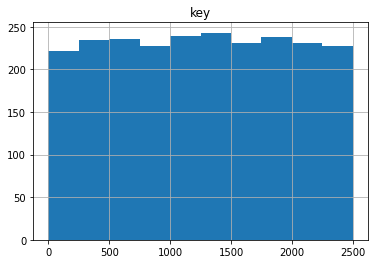

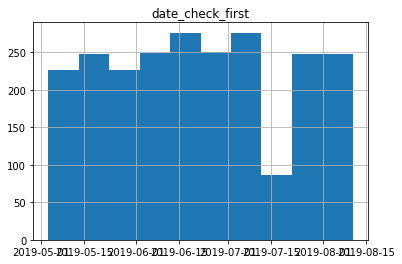

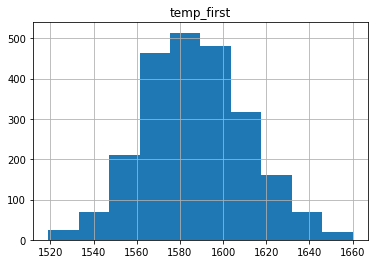

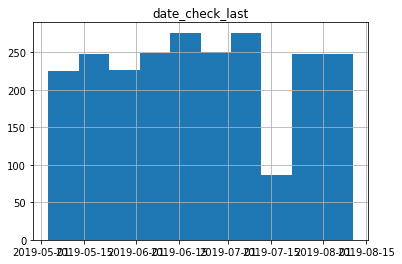

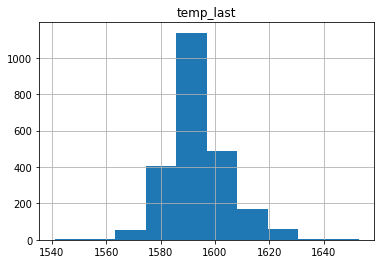

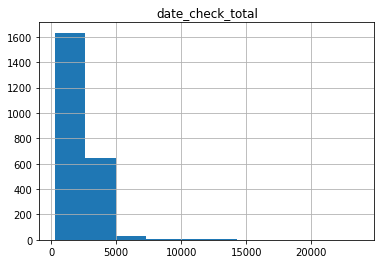

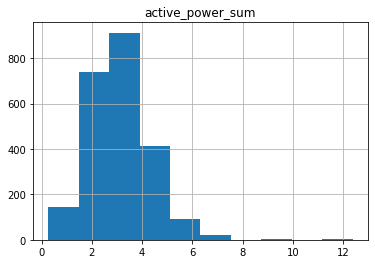

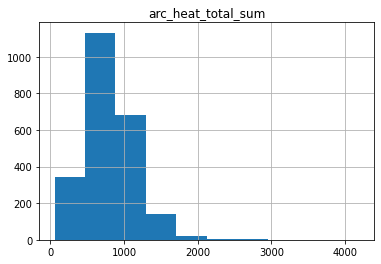

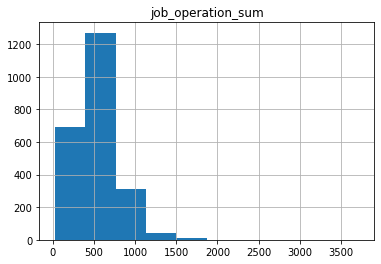

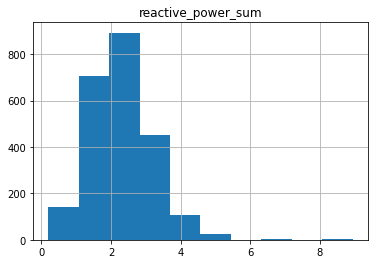

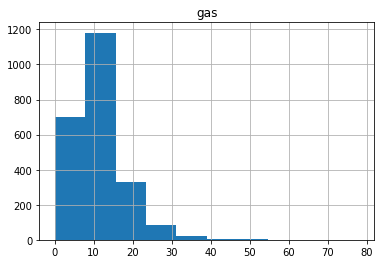

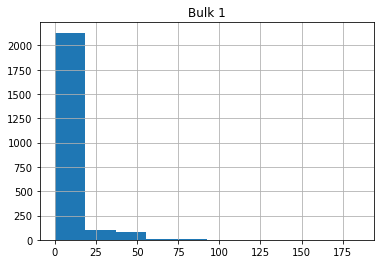

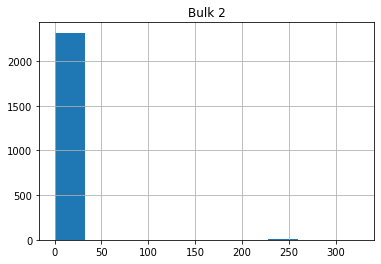

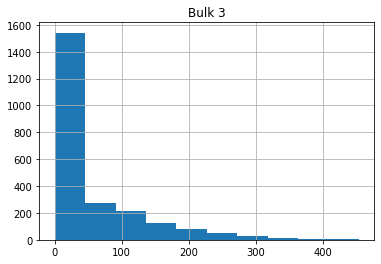

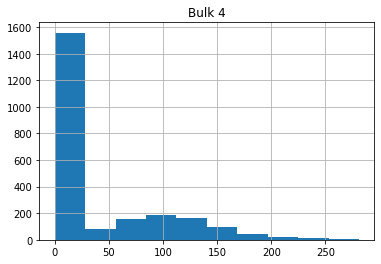

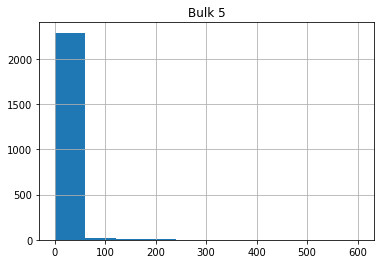

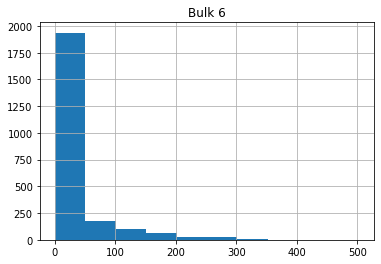

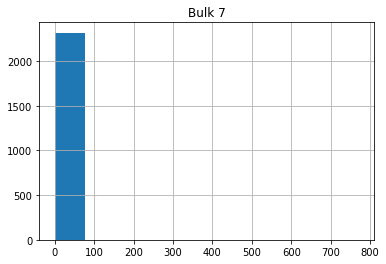

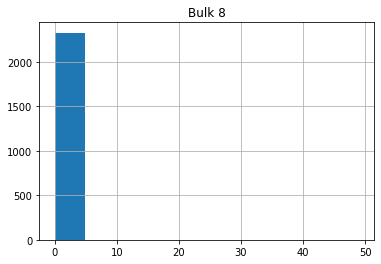

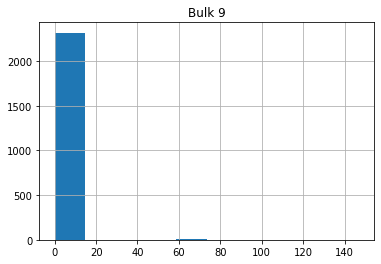

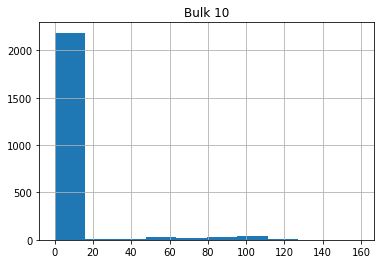

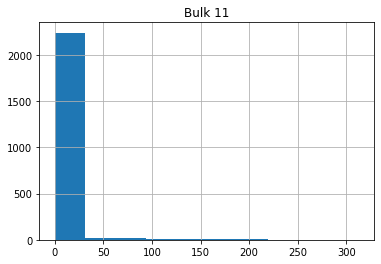

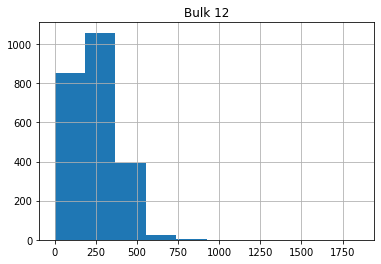

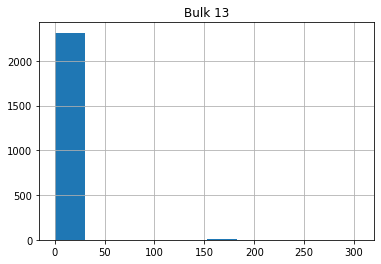

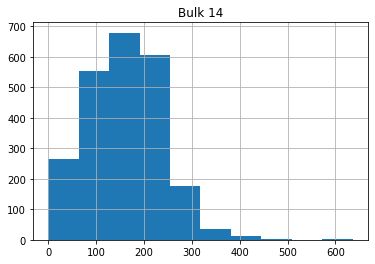

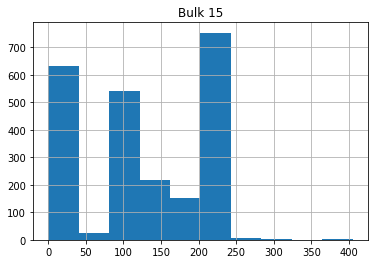

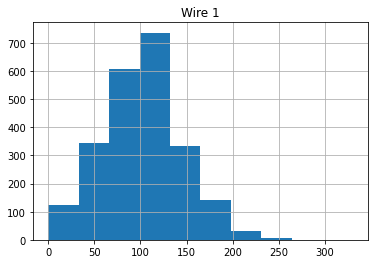

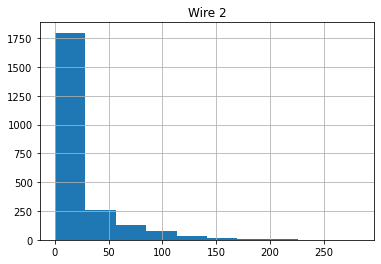

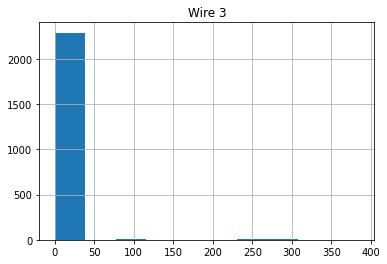

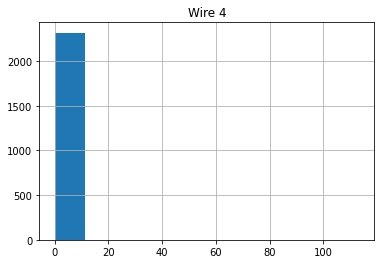

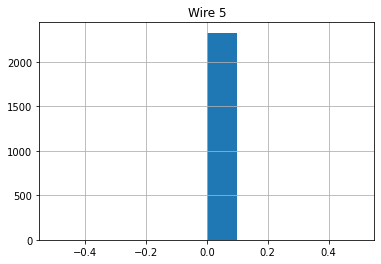

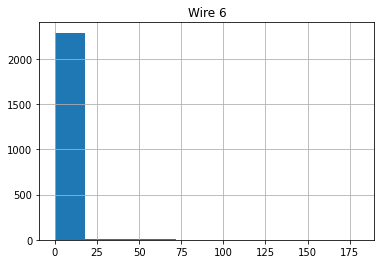

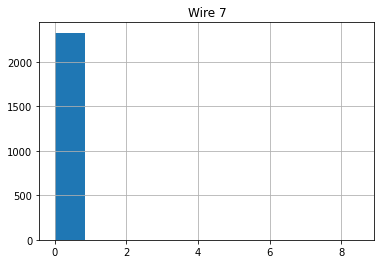

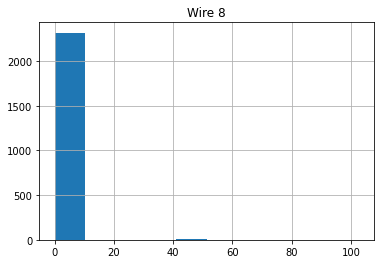

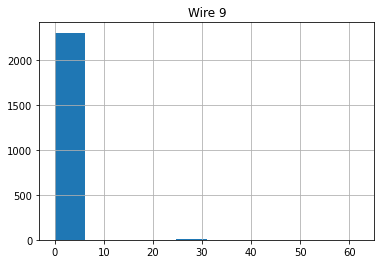

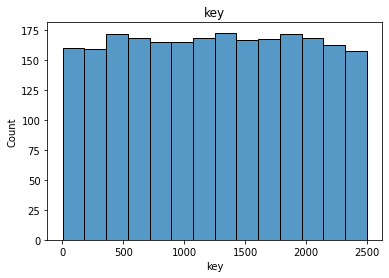

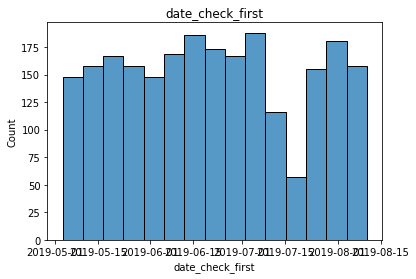

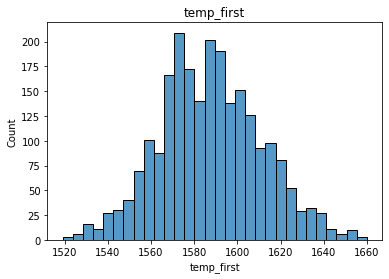

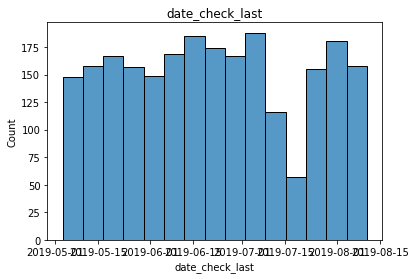

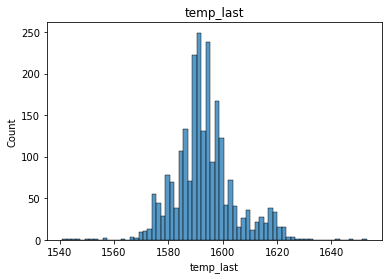

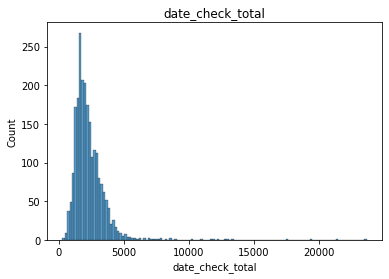

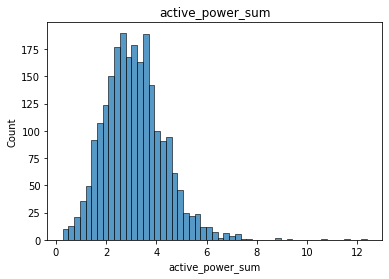

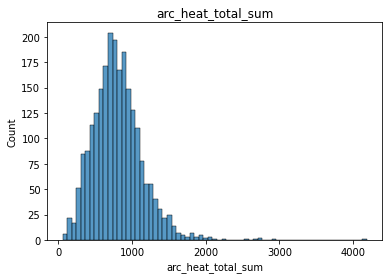

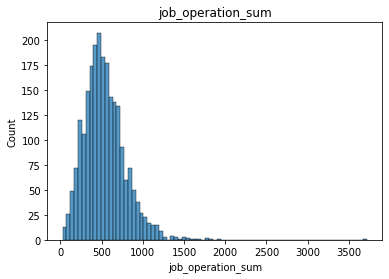

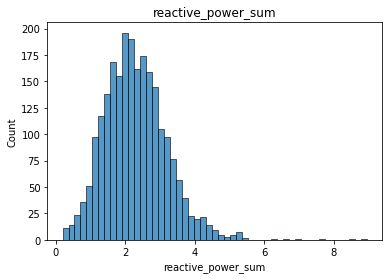

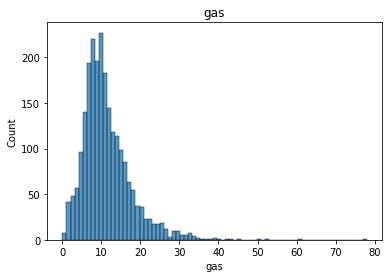

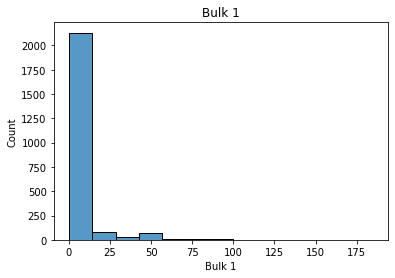

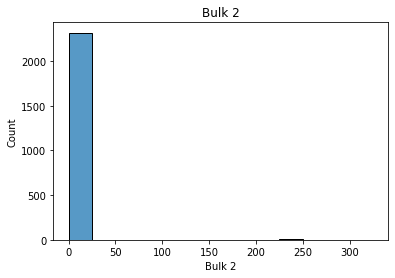

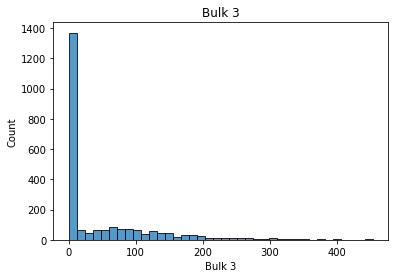

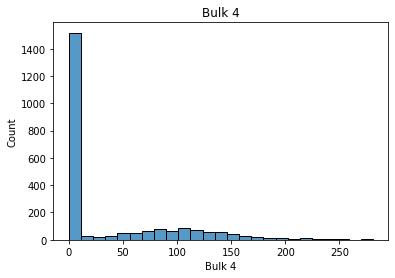

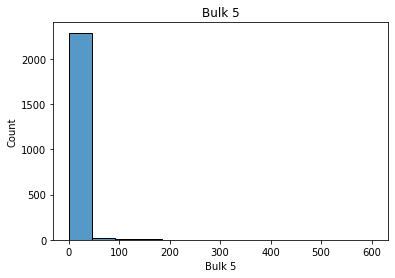

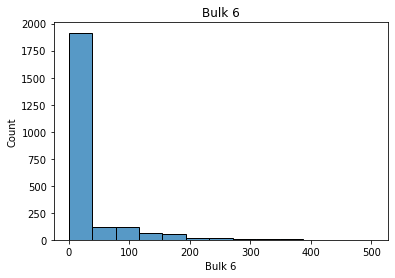

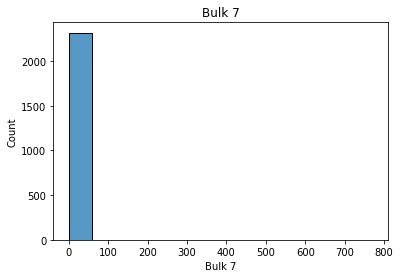

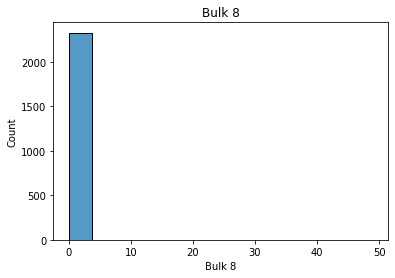

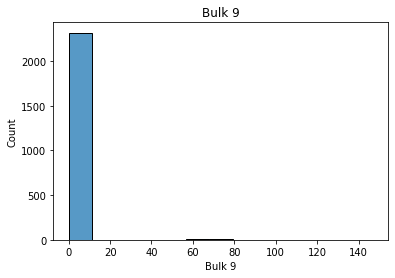

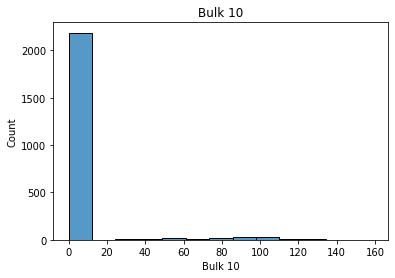

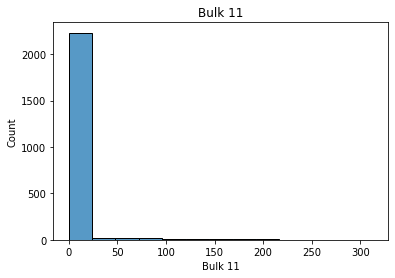

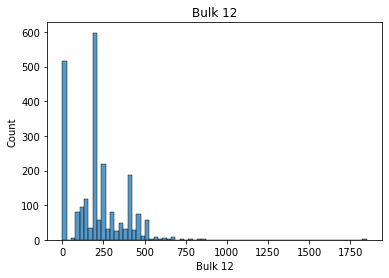

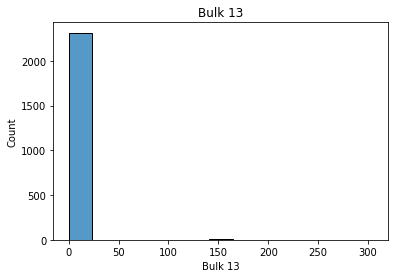

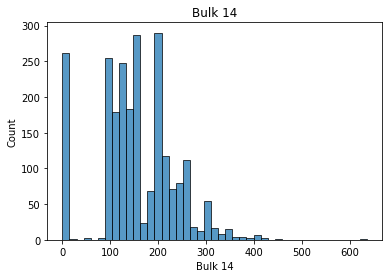

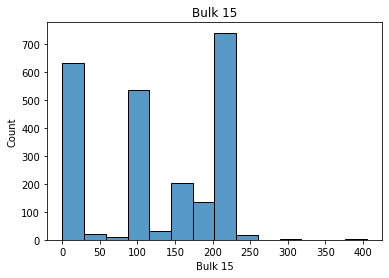

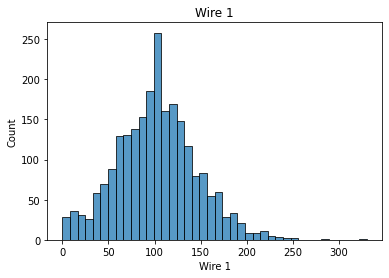

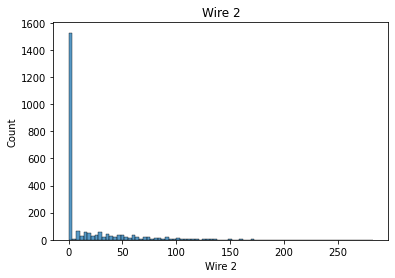

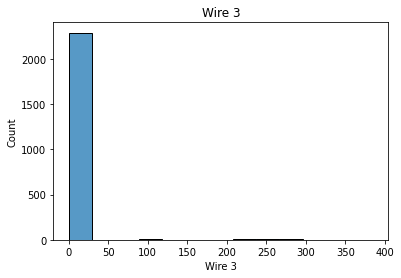

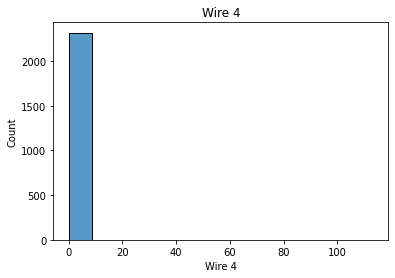

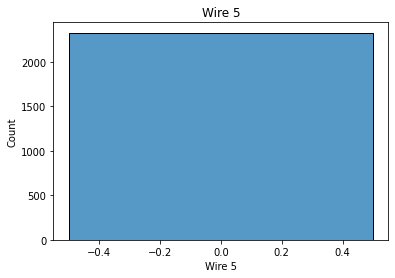

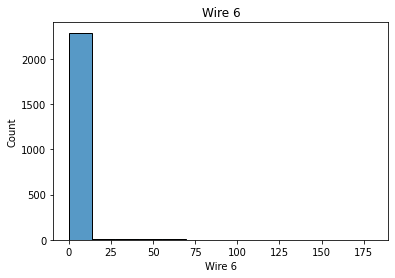

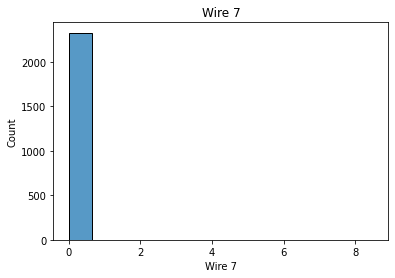

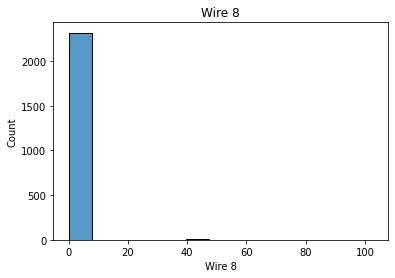

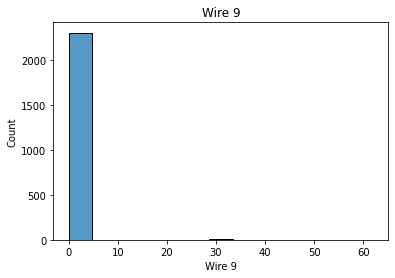

In [43]:
# Графики распределения признаков с помощью matplotlib
for column in df_final.columns:
    plt.figure()
    df_final[column].hist()
    plt.title(column)
    plt.show()

# Графики распределения признаков с помощью seaborn
for column in df_final.columns:
    plt.figure()
    sns.histplot(data=df_final, x=column)
    plt.title(column)
    plt.show()

В результате анализа данных мы обнаружили сильную корреляцию между следующими признаками:

- Работы и общего время нагрева дугой
- Реактивная мощность и активная мощность
- Wire 8 и Bulk 9
- Wire 4 и Bulk 2
- Wire 5 в корреляции пустой
- Работа, время нагрева дуги и реактивная мощность

На графиках распределения имеются в большенстве сыпучих материалах и проволоках не нормальные распределения. Это могло произойти из за того что эти материалы редко добавляли при варке стали, и заполнение нулями дало такой результат.

Чтобы наша модель смогла пройти обучение небходимо будет удалить признаки с форматом datetime. Также можно удалить столбец key, т.к для обучения он бесполезен

In [44]:
# model_final_df = df_final.copy()
df_final= df_final.drop(columns=['key','date_check_first','date_check_last'])
df_final

,temp_first,temp_last,date_check_total,active_power_sum,arc_heat_total_sum,job_operation_sum,reactive_power_sum,gas,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1571.0,1613.0,1714.0,3.036730,1098.0,628.616930,2.142821,29.749986,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,1265.0,2.139408,811.0,395.281800,1.453357,12.555561,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,1753.0,4.063641,655.0,581.774624,2.937457,28.554793,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,1220.0,2.706489,741.0,543.710274,2.056992,18.841219,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,1536.0,2.252950,869.0,412.180480,1.687991,5.413692,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,1570.0,1591.0,1380.0,3.168133,723.0,571.539318,2.210936,7.125735,0.0,0.0,...,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2325,1554.0,1591.0,1705.0,4.174918,940.0,675.222467,2.872031,9.412616,0.0,0.0,...,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2326,1571.0,1589.0,962.0,3.605239,569.0,680.326674,2.452092,6.271699,0.0,0.0,...,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2327,1591.0,1594.0,1520.0,3.202310,750.0,474.918795,2.239820,14.953657,0.0,0.0,...,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Можно переходить к разделению датасета на выборки и обучению моделей.

## Обучение моделей

In [45]:
x = df_final.drop(columns='temp_last')
y = df_final['temp_last']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=RANDOM_STATE, shuffle=True)

In [46]:
print("Размеры выборок:")
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Размеры выборок:
x_train: (1746, 31)
x_test: (583, 31)
y_train: (1746,)
y_test: (583,)


**Протестируем модель CatBoostRegressor**

In [47]:
model_cat = CatBoostRegressor(verbose=2, loss_function="RMSE")

param_cv = {
    'learning_rate': [0.5, 0.1, 1],
    'n_estimators': range(100, 500)
}

model_cat_cv = RandomizedSearchCV(
    model_cat,
    param_cv,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=2,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

model_cat_cv.fit(x_train, y_train)
mae = (model_cat_cv.best_score_ * -1)
print('MAE на обучающей выборке данных:', format(mae, '.3f'))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
0:	learn: 9.7991671	total: 55.6ms	remaining: 14.6s
2:	learn: 8.6518248	total: 65.8ms	remaining: 5.7s
4:	learn: 7.8359998	total: 72.9ms	remaining: 3.76s
6:	learn: 7.4420250	total: 79.6ms	remaining: 2.91s
8:	learn: 7.2403490	total: 86.1ms	remaining: 2.43s
10:	learn: 7.0283338	total: 92.9ms	remaining: 2.13s
12:	learn: 6.8746300	total: 100ms	remaining: 1.93s
14:	learn: 6.6583905	total: 107ms	remaining: 1.76s
16:	learn: 6.4278569	total: 113ms	remaining: 1.64s
18:	learn: 6.2337047	total: 120ms	remaining: 1.54s
20:	learn: 5.9881158	total: 127ms	remaining: 1.47s
22:	learn: 5.8338180	total: 134ms	remaining: 1.39s
24:	learn: 5.6450276	total: 141ms	remaining: 1.34s
26:	learn: 5.4732709	total: 148ms	remaining: 1.29s
28:	learn: 5.3461467	total: 155ms	remaining: 1.25s
30:	learn: 5.2059281	total: 162ms	remaining: 1.21s
32:	learn: 5.1307369	total: 169ms	remaining: 1.17s
34:	learn: 5.0199253	total: 175ms	remaining: 1.14s
36:	learn: 4.8334898	t

MAE на обучающей выборке данных для модели CatBoostRegressor: 5.819

**Протестируем модель Случайного леса**

In [48]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

param = {'n_estimators': range(5, 7, 10), 'max_depth': range(1, 15)}

model_rf_cv = RandomizedSearchCV(
    model_rf,
    param,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=2,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

model_rf_cv.fit(x_train, y_train)
mae = (model_rf_cv.best_score_ * -1)
best_params = model_rf_cv.best_params_
print("MAE на обучающей выборке:", format(mae, '.3f'), "Лучшие параметры:", best_params)


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.0s
[CV] END ........................max_depth=5, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.0s
[CV] END .......................max_depth=11, n_estimators=5; total time=   0.0s
MAE на обучающей выборке: 6.486 Лучшие параметры: {'n_estimators': 5, 'max_depth': 11}


MAE на обучающей выборке данных для модели Случайного леса: 6.486. Лучшие параметры: 'n_estimators':5, 'max_depth': 11

**Протестируем модель LGBMRegressor**

In [49]:
model_lgb = LGBMRegressor(n_jobs=1, objective='regression', num_leaves=25, learning_rate=0.05, n_estimators=7)

param_cv = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': range(50, 200, 50),
}

model_lgb_cv = RandomizedSearchCV(
    model_lgb,
    param_cv,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=2,
    n_jobs=-1,
    verbose=False,
    random_state=RANDOM_STATE
)

model_lgb_cv.fit(x_train, y_train)
mae = (model_lgb_cv.best_score_ * -1)
best_params = model_lgb_cv.best_params_
print("MAE на обучающей выборке:", format(mae, '.3f'), "Лучшие параметры:", best_params)


MAE на обучающей выборке: 5.836 Лучшие параметры: {'n_estimators': 100, 'learning_rate': 0.05}


MAE на обучающей выборке данных для модели LGBMRegressor: 5.836. Лучшие параметры:'n_estimators': 100, 'learning_rate': 0.05

Лучше всего себя показала модель CatBoostRegressor, с метрикой MAE 5.819. Протестируем ее на финальной выборке

### Тестирование модели

In [50]:
predict =model_cat_cv.predict(x_test)
mae_final_model = mean_absolute_error(y_test, predict)
print('MAE на тестовой выборке:',format(mae_final_model, '.3f'))

MAE на тестовой выборке: 5.958


Проведем проверку на константной модели, чтобы убедиться что наша модель адекватна

In [51]:
target_constant = y_test.mean()
y_pred = np.full_like(y_test, target_constant)
mae_const = mean_absolute_error(y_test, y_pred)

print("MAE для константной модели: ", format(mae_const, '.3f'))


MAE для константной модели:  8.293


MAE на константной моделе равняется 8.293, значит наша модель прошла проверку

### Определение самых важных признаков для обучения модели

In [52]:
model_cat = model_cat.fit(x, y)
x_main = pd.DataFrame(sorted(zip(model_cat.feature_importances_, x_test.columns)), columns=['Относительная важность'
                                                                                                 , 'Признаки'])

Learning rate set to 0.046794
0:	learn: 11.0518149	total: 5.32ms	remaining: 5.32s
2:	learn: 10.8057201	total: 13.7ms	remaining: 4.57s
4:	learn: 10.5658492	total: 22.1ms	remaining: 4.4s
6:	learn: 10.3686221	total: 31.2ms	remaining: 4.43s
8:	learn: 10.1962415	total: 39.4ms	remaining: 4.33s
10:	learn: 10.0386070	total: 48ms	remaining: 4.31s
12:	learn: 9.8669307	total: 57ms	remaining: 4.33s
14:	learn: 9.7390408	total: 65.9ms	remaining: 4.33s
16:	learn: 9.6013737	total: 74.7ms	remaining: 4.32s
18:	learn: 9.4742632	total: 83.2ms	remaining: 4.29s
20:	learn: 9.3583112	total: 91.1ms	remaining: 4.25s
22:	learn: 9.2436973	total: 99.2ms	remaining: 4.21s
24:	learn: 9.1478241	total: 107ms	remaining: 4.18s
26:	learn: 9.0534187	total: 116ms	remaining: 4.17s
28:	learn: 8.9726125	total: 124ms	remaining: 4.16s
30:	learn: 8.9109149	total: 132ms	remaining: 4.13s
32:	learn: 8.8349458	total: 140ms	remaining: 4.11s
34:	learn: 8.7696755	total: 148ms	remaining: 4.08s
36:	learn: 8.7067021	total: 157ms	remaining:

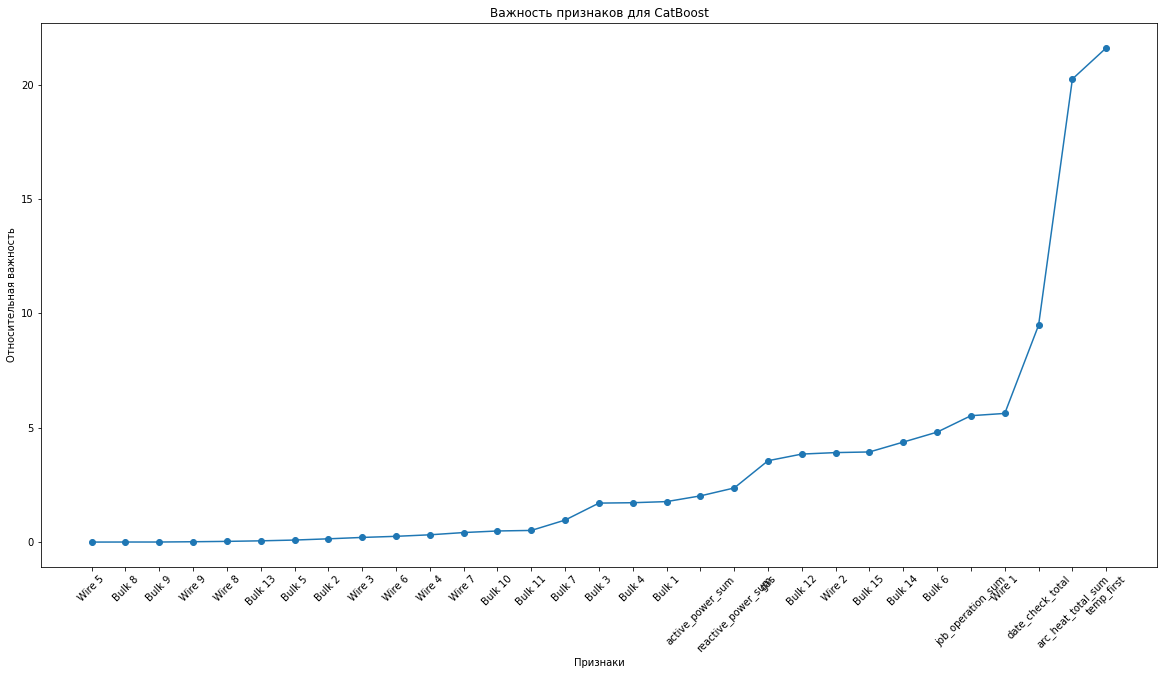

In [53]:
plt.figure(figsize=(20, 10))
plt.plot(x_main['Признаки'], x_main['Относительная важность'], marker='o')
plt.title('Важность признаков для CatBoost')
plt.xlabel('Признаки')
plt.ylabel('Относительная важность')
plt.xticks(rotation=45)
plt.show()

**По графику можно сделать вывод:** 

- Особенно важным признаом являются начальная температура
- Общее варки партии
- Виды проволоки 1,2
- Виды сыпучиих материалов 12,14,15,6
- Общее время нагрева дугой
- Сумма работы
- Сумма активной и реактивной мощности

## Вывод

Мы провели подробное исследование, чтобы использовать все доступные данные от заказчика. Создали необходимые признаки, которые помогли обучить модель и повысить качество обучения. Исследовали матрицу кореляций признаков и выявили предварительно самые значимые признаки.

Обучили три модели: Случайный лес, LGBMRegressor, CatBoostRegressor.

После сравнения метрик качества предсказаний от этих моделей мы обнаружили, что CatBoostRegressor является лидером, достигнув значения **MAE 5.958 на тестовой выборке.**

Мы успешно достигли требуемого значения. Дополнительно определили наиболее значимые признаки, на которых основывается предсказание нашей лучшей модели. 

**Самые важные признаки:** 

- Начальная температура
- Общее время нагрева партии
- Добавление проволоки №1
- Сумма работы

## Отчет по исследованию

Для комбината ООО "Так закаляем сталь" было проведено исследование целью которого было найти способ оптимизировать расходы для процесса варки стали. Для такого исследования мы провели исследовательский анализ всех данных предоставленных от заказчика и построили модель которая сможет предсказать конечную температуру стали на основе данных о добавлении всех материлов которые используются при варке стали, данных о начальных температурах и прочих данных которые мы получили от заказчика.


### Сравнение решения и плана

В начальном плане были предусмотрены следующие шаги:

- Предварительный анализ данных: изучение каждого файла с данными, обработка пропущенных значений и выбросов, а также объединение необходимых данных.
- Создание признаков: создание новых признаков на основе доступных данных.
- Построение модели: выбор подходящей модели машинного обучения (например, линейная регрессия, случайный лес или градиентный бустинг), обучение модели на подготовленных данных и оценка ее качества.
- Оптимизация модели: настройка гиперпараметров модели и применение методов оптимизации для улучшения ее качества.
- Валидация модели: оценка качества модели кросс-валидацией на обучающей выборке, подбор лучших параметров и модели.
- Финальная проверка лучшей модели на тестовой выборке

Все шаги которые были описаны в предварительном плане работы были выполнены успешно без отклонений

### Описание трудностей проекта и как они были решены

1)

**Трудность:** В данных таблиц о подаче сыпучих метериалов и проволок были допущены пропуски которые скорее всего связаны с тем, что данный материал не учавствовал в этой итерации или этапе

**Решение**
Такие данные мы заменили нулями.

____________________________________

2)

**Трудность:** В данных об электродах была найдена аномалия в столбце Реактивной мощности

**Решение**
Эти данные мы просто удалили, т.к это был единичный выброс
____________________________________

3)

**Трудность:** В данных об температуре были обнаружены партии с потерями изменения температур

**Решение**
Такие данные были удалены.


Так же во всех датасетах были изменены форматы данных на стандартные и название столбцов в данных были преведены к стандартным

### Описание ключевых шагов решения

**Одним из важнеших и ключевых шагов оказался - Создание признаков.** 
Добавление новых признаков позволило повысить качество. Из данных которые предоставил заказчик мы смогли составить следующие признаки, которые помогли повысить качество обучения модели:


1. Время между первым и последним замером температуры.
2. Общее время нагрева дугой для каждой партии
3. Суммарная работа для партии
4. Суммарная рекативная мощность для партии
5. Суммарная активная мощность для партии

### Признаки, которые использовали для обучения Итоговой модели

Для обучения модели были использованы следующие признаки:

- temp_first -  Начальная температура              
- date_check_total - Время между первым и последним замером температуры. 
- active_power_sum - Суммарная активная мощность для партии
- arc_heat_total_sum - Общее время нагрева дугой для каждой партии   
- job_operation_sum  - Суммарная работа для партии
- reactive_power_sum  - Суммарная рекативная мощность для партии
- gas - Данны о продувке газом                

Сыпучие материалы:
Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15    

Проволоки:
Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9 

Шаги предобработки признаков во время исследования:

Данные проверялись на наличие дубликатов и удаление их, если они есть. Дубликаты могут исказить результаты и привести к переобучению модели. **Важно отметить, что дубликтов всех признаков в данных не оказалось**

Признаки обрабатывались на наличие пропущенных значений и применение подходящей стратегии их переработки. Это может включать удаление записей с пропущенными значениями, заполнение их средними или медианными значениями, или использование специального значения, обозначающего отсутствие информации. В нашем исследовании пропущенные значения в данных о добавлении сыпучих материалов и проволок мы заполнили нулями, т.к это могло означать что в данной итерации эти материалы не использовались и их значение равно нулю. Для строк с пропусками в данными о температурах было принято решение удалить эти строки. 

Признаки исследовались на наличие выбросов, которые могут сильно исказить результаты модели. Выбросы были найдены в признаке Реактивной мощности и так же были удалены.


Также были созданы новые признаки на основе данных полученных от закачика, о которых было упомянуто в предидущем пункте отчета для исследования.

Помимо всего вышеуказанного, данные которые имели неверный формат были привидены к стандартному виду для этих значений. Также названия призаков были приведены к стандартному виду (названия признаков на кириллице были заменены латиницей). 

### Полное описание Итоговой модели

Для достижения наилучшего качества предсказаний мы обучили три модели: LGBMRegressor,  Случайного леса и CatBoostRegressor, и сравнили их по ключевым метрикам. После сравнения показателей метрик мы выбрали CatBoostRegressor, у которой значение было равно наилучшему. **MAE на тестовой выборке для модели CatBoostRegressor составил:  5.958**

Более детально об этой модели и ее гиперпараметрах:

Эта модель инициализируется с параметрами verbose=2 и loss_function="RMSE". Параметр verbose=2 обеспечивает вывод подробной информации о процессе обучения модели, а параметр loss_function="RMSE" указывает на использование функции потерь RMSE (корень из среднеквадратичной ошибки) во время обучения модели.

Далее был задан словарь параметров для кросс-валидации (param_cv), который включает следующие гиперпараметры:

learning_rate : [0.5, 0.1, 1]
n_estimators : range(100, 500)

В данном случае, для параметра learning_rate рассматриваются значения [0.5, 0.1, 1], а для параметра n_estimators рассматривается диапазон значений от 100 до 500

Затем был создан объект RandomizedSearchCV для выполнения случайного поиска по заданным гиперпараметрам модели:

model_cat_cv = RandomizedSearchCV(
    model_cat,
    param_cv,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=2,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE)
    
В этом случае модель используется в качестве базовой модели для RandomizedSearchCV. Параметр scoring='neg_mean_absolute_error' указывает на использование отрицательной абсолютной ошибки в качестве метрики оценки модели. Параметр cv=5 определяет количество блоков в кросс-валидации, n_iter=2 задает количество случайных комбинаций гиперпараметров для случайного поиска, а n_jobs=-1 указывает на использование всех доступных ядер процессора для выполнения поиска параллельно. Параметр verbose=2 обеспечивает вывод подробной информации о процессе поиска, а random_state=RANDOM_STATE задает состояние генератора случайных чисел для воспроизводимости результатов.

Также на графике важности мы заметили, что основное влияние на предсказание модели оказывают начальная температура и время нагрева. Это говорит о том, что вероятнее всего можно достичь цели по оптимизации производственных расходов на энергоресурсы, воздействуя на начальную температуру.

Таким образом, мы подобрали оптимальную модель, способную довольно точно предсказывать

**Финальное MAE на тестовой выборке для модели CatBoostRegressor составил: 5.958**, что является успешным результатом этого исследования